In [1]:
import os
import re
import numpy as np
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
from astropy.io import fits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d
from numpy.polynomial.chebyshev import Chebyshev
from tqdm import tqdm  # For progress bars
from collections import defaultdict
import corner
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# # Define the path to the allStar catalog
# allstar_file = 'lab2_data/allStar-dr17-synspec_rev1.fits'

# # Open the FITS file and read the data
# with fits.open(allstar_file) as hdulist:
#     data = Table(hdulist[1].data)

In [3]:
# # List of fields of interest
# fields = ['M15', 'N6791', 'K2_C4_168-21', '060+00']

# # Filter data based on the 'FIELD' column
# data_filtered = data[np.isin(data['FIELD'], fields)]

# # Create a mask for entries with all required labels present
# labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
# mask = np.ones(len(data_filtered), dtype=bool)
# for label in labels:
#     mask &= ~np.isnan(data_filtered[label])

# data_filtered = data_filtered[mask]

# # Apply SNR >= 50 cut
# data_filtered = data_filtered[data_filtered['SNR'] >= 50]

# # Exclude stars with LOGG > 4 or TEFF > 5700 K
# data_filtered = data_filtered[(data_filtered['LOGG'] <= 4) & (data_filtered['TEFF'] <= 5700)]

# # Exclude stars with FE_H < -1
# data_filtered = data_filtered[data_filtered['FE_H'] >= -1]

# print(f"Total number of stars: {len(data_filtered)}")

# # Save the filtered Astropy Table to a FITS file
# data_filtered.write('lab2_data/filtered_training_set.fits', overwrite=True)

# print("Filtered Astropy Table saved to 'lab2_data/filtered_training_set.fits'")

In [4]:
# # Define the base URLs
# aspcap_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1"
# apstar_base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars"

# # Extract the relevant columns from the filtered data
# apogee_ids = data_filtered['APOGEE_ID']
# telescopes = data_filtered['TELESCOPE']
# fields = data_filtered['FIELD']

# # Define the folder to save the spectra
# output_folder = "lab2_data/apStar_spectra"
# os.makedirs(output_folder, exist_ok=True)

# # Function to download a file from a given URL
# def download_spectra(url, filename):
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open(filename, 'wb') as file:
#             file.write(response.content)
#         print(f"Downloaded: {filename}")
#     else:
#         print(f"Failed to download: {url}")

# # Loop over the filtered data and construct the URLs
# for apogee_id, telescope, field in zip(apogee_ids, telescopes, fields):
#     # Construct the apStar file URL
#     apstar_url = f"{apstar_base_url}/{telescope}/{field}/apStar-dr17-{apogee_id}.fits"
#     apstar_filename = os.path.join(output_folder, f"apStar-dr17-{apogee_id}.fits")
    
#     # Download the apStar file
#     download_spectra(apstar_url, apstar_filename)

In [5]:
def load_filtered_training_set(filepath='lab2_data/filtered_training_set.fits'):
    data_filtered = Table.read(filepath)
    return data_filtered


In [6]:
def plot_apstar_spectrum(apstar_filename, downsample_factor=1):
    # Open the FITS file
    with fits.open(apstar_filename) as hdulist:
        # Extract coadded flux (multi-visit spectrum)
        flux = hdulist[1].data  # Coadded flux data is in the second HDU
        header = hdulist[1].header  # Header contains necessary metadata
        
        # Debug: Check the shape of flux
        print("Flux shape before processing:", flux.shape)
        
        # Handle multi-dimensional flux data
        if flux.ndim > 1:
            # Option 2: Select a specific spectrum
            flux = flux[0]  
            print("Flux shape after flattening:", flux.shape)
        
        # Reconstruct the wavelength array
        crval = header['CRVAL1']  # Starting wavelength
        cdelt = header['CDELT1']  # Wavelength step (Δλ)
        num_pixels = len(flux)     # Number of flux points (pixels)
        wavelength = crval + cdelt * np.arange(num_pixels)

        # Downsample the data by averaging over groups of points
        downsampled_wavelength = wavelength[::downsample_factor]
        downsampled_flux = flux[::downsample_factor]

        # Plot downsampled flux vs wavelength
        plt.figure(figsize=(12, 6))
        plt.plot(downsampled_wavelength, downsampled_flux, label='Downsampled Spectrum', 
                 color='#1f77b4', linewidth=0.8, alpha=0.9)
        
        # Enhance the plot
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Flux (Arbitrary Units)', fontsize=12)
        plt.title(f'Spectrum (Downsampled): {os.path.basename(apstar_filename)}', fontsize=14)
        plt.legend(fontsize=10)
        
        # Add grid for better readability
        plt.grid(True, alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.show()


In [7]:
def extract_unique_id(filename):
    # Updated regex: case-insensitive, captures unique ID with or without '.fits'
    match = re.search(r'(2M\d+[+-]\d+)', filename, re.IGNORECASE)
    if match:
        unique_id = match.group(1).upper()
        return unique_id
    else:
        logging.warning(f"Failed to extract Unique ID from filename: {filename}")
        return None


In [8]:
def process_spectrum_with_bitmask(apstar_filename, large_error_value=1e10, plot=False, plot_bad_pixels=True):
    with fits.open(apstar_filename) as hdulist:
        flux = hdulist[1].data
        error = hdulist[2].data
        bitmask = hdulist[3].data
        header = hdulist[1].header

        if flux.ndim > 1:
            flux = flux[0]
            error = error[0]
            bitmask = bitmask[0]

        crval = header['CRVAL1']  # Starting log10(wavelength)
        cdelt = header['CDELT1']  # Delta log10(wavelength)
        num_pixels = len(flux)
        logwavelength = crval + cdelt * np.arange(num_pixels)
        wavelength = 10 ** logwavelength  # Convert to linear Å

        max_wavelength = 16950
        valid_mask = wavelength <= max_wavelength
        wavelength = wavelength[valid_mask]
        flux = flux[valid_mask]
        error = error[valid_mask]
        bitmask = bitmask[valid_mask]

        bad_bits_mask = (
            (bitmask & (1 << 0)) |   # BADPIX
            (bitmask & (1 << 1)) |   # CRPIX
            (bitmask & (1 << 2)) |   # SATPIX
            (bitmask & (1 << 3)) |   # UNFIXABLE
            (bitmask & (1 << 4)) |   # BADDARK
            (bitmask & (1 << 5)) |   # BADFLAT
            (bitmask & (1 << 6)) |   # BADERR
            (bitmask & (1 << 7)) |   # NOSKY
            (bitmask & (1 << 12))    # SIG_SKYLINE
        )
        bad_pixel_mask = bad_bits_mask > 0
        error[bad_pixel_mask] = large_error_value

        print(f"Processed {apstar_filename}:")
        print(f" - Number of valid pixels: {len(wavelength)}")
        print(f" - Number of bad pixels: {np.sum(bad_pixel_mask)}")

        if plot:
            # Plot the spectrum (flux) first
            plt.figure(figsize=(12, 6))
            
            plt.plot(wavelength, flux, label='Spectrum', color='#1f77b4', linewidth=0.5, zorder=1)
            if plot_bad_pixels:
                plt.scatter(wavelength[bad_pixel_mask], flux[bad_pixel_mask], color='#d62728', s=2, label='Bad Pixels', zorder=2, alpha=0.8)
                plt.title(f'Spectrum with Bad Pixels Marked: {os.path.basename(apstar_filename)}', fontsize=14)
            else:
                plt.title(f'Spectrum: {os.path.basename(apstar_filename)}', fontsize=14)
            
            # Set labels and title
            plt.xlabel('Wavelength (Å)', fontsize=12)
            plt.ylabel('Flux (Arbitrary Units)', fontsize=12)
            
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3, linestyle='--')
        
            
            plt.tight_layout()
            plt.show()

        return flux, error, wavelength, bad_pixel_mask, apstar_filename


In [9]:
def load_continuum_pixels(filename):
    continuum_data = np.load(filename)
    continuum_wavelengths = continuum_data['wavelengths'][continuum_data['trusted']]
    return continuum_wavelengths


In [10]:
def find_closest_indices(spectrum_wavelengths, target_wavelengths):
    if len(spectrum_wavelengths) == 0 or len(target_wavelengths) == 0:
        print("find_closest_indices: One of the input arrays is empty.")
        return np.array([])  # Return empty array if either input is empty

    indices = np.searchsorted(spectrum_wavelengths, target_wavelengths)
    indices = np.clip(indices, 1, len(spectrum_wavelengths) - 1)
    left = spectrum_wavelengths[indices - 1]
    right = spectrum_wavelengths[indices]
    comparison = np.abs(target_wavelengths - left) < np.abs(target_wavelengths - right)
    indices -= comparison.astype(int)

    # Debugging statements
    print(f"find_closest_indices: Found {len(indices)} indices.")
    print(f"find_closest_indices: Example indices: {indices[:5]}")
    return indices


In [11]:
def normalize_spectrum(flux, wavelength, bad_pixel_mask, continuum_wavelengths, plot=False):
    # Exclude bad pixels
    flux = flux[~bad_pixel_mask]
    wavelength = wavelength[~bad_pixel_mask]

    print(f" - After excluding bad pixels: {len(wavelength)} pixels")
    print(f" - Wavelength range: {wavelength.min():.2f} Å - {wavelength.max():.2f} Å")

    # Define wavelength ranges for each chip
    chip_wavelength_ranges = [
        (15140, 15810),  # Chip 1
        (15860, 16430),  # Chip 2
        (16470, 16950)   # Chip 3
    ]

    # Initialize continuum
    continuum = np.zeros_like(flux)

    # Process each chip
    for chip_min_wave, chip_max_wave in chip_wavelength_ranges:
        chip_mask = (wavelength >= chip_min_wave) & (wavelength <= chip_max_wave)
        chip_wavelength = wavelength[chip_mask]
        chip_flux = flux[chip_mask]

        print(f"   - Chip {chip_min_wave}-{chip_max_wave} Å: {len(chip_wavelength)} pixels")

        # Continuum points in this chip
        chip_cont_mask = (continuum_wavelengths >= chip_min_wave) & (continuum_wavelengths <= chip_max_wave)
        chip_cont_wavelength = continuum_wavelengths[chip_cont_mask]

        print(f"     - Continuum points in chip: {len(chip_cont_wavelength)}")

        if len(chip_wavelength) == 0:
            print("     * No pixels in this chip. Skipping.")
            continue  # Skip if no pixels in chip

        if len(chip_cont_wavelength) == 0:
            # No continuum points in this chip, use running median
            print("     * No continuum points found. Using running median.")
            continuum_chip = running_median(chip_flux, window_size=50)
        else:
            # Find closest indices
            continuum_indices = find_closest_indices(chip_wavelength, chip_cont_wavelength)

            if len(continuum_indices) == 0:
                print("     * No continuum indices found. Using running median.")
                continuum_chip = running_median(chip_flux, window_size=50)
            else:
                continuum_flux = chip_flux[continuum_indices]

                # Fit Chebyshev polynomial
                try:
                    cheb_fit = Chebyshev.fit(chip_cont_wavelength, continuum_flux, deg=2)
                    continuum_chip = cheb_fit(chip_wavelength)
                    print("     * Fitted Chebyshev polynomial.")
                except Exception as e:
                    print(f"     * Chebyshev fitting failed: {e}. Using running median.")
                    continuum_chip = running_median(chip_flux, window_size=50)

        continuum[chip_mask] = continuum_chip

    # Handle zero continuum
    zero_continuum_mask = (continuum == 0)
    continuum[zero_continuum_mask] = np.nan

    # Normalize
    normalized_flux = flux / continuum

    # Check if normalized_flux has valid values
    if np.all(np.isnan(normalized_flux)):
        print("Warning: All normalized flux values are NaN.")
    else:
        print(" - Normalization successful.")

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(wavelength, flux, label='Un-normalized Spectrum', color='#1f77b4', alpha=0.8, linewidth=0.5)
        plt.plot(wavelength, continuum, label='Estimated Continuum', color='#d62728', alpha=1, linewidth=1.5)
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Flux', fontsize=12)
        plt.title('Un-normalized Spectrum with Estimated Continuum', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Plot Normalized Flux
        plt.figure(figsize=(12, 6))
        plt.plot(wavelength, normalized_flux, label='Normalized Spectrum', color='#2ca02c', alpha=0.8, linewidth=0.5)
        plt.xlabel('Wavelength (Å)', fontsize=12)
        plt.ylabel('Normalized Flux', fontsize=12)
        plt.title('Normalized Spectrum Across All Chips', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.tight_layout()
        plt.show()

    return normalized_flux, wavelength


In [12]:
def split_spectra_for_training(labels, flux, test_size=0.2, random_state=42):
    train_labels, cv_labels, train_flux, cv_flux = train_test_split(
        labels, flux, test_size=test_size, random_state=random_state
    )
    return (train_labels, train_flux), (cv_labels, cv_flux)


In [13]:
# Step 1: Load the filtered training set
data_filtered = Table.read('lab2_data/filtered_training_set.fits')

# Step 2: Extract label data
labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']

# Initialize a list to hold label data
label_data_list = []

for label in labels:
    column = data_filtered[label]
    if hasattr(column, 'filled'):
        # Column is masked; fill masked values with np.nan
        label_values = column.filled(np.nan)
    else:
        # Column is not masked; extract data directly
        label_values = column.data
    label_data_list.append(label_values)

# Stack the label data into a 2D NumPy array
label_data = np.vstack(label_data_list).T

print(f"Label data shape: {label_data.shape}")  # Expected: (1886, 5)


Label data shape: (1886, 5)


In [14]:
# Step 3: Remove entries with missing label data
valid_label_mask = ~np.isnan(label_data).any(axis=1)
data_filtered_matched = data_filtered[valid_label_mask]
label_data_matched = label_data[valid_label_mask]

print(f"Label data shape after cleaning: {label_data_matched.shape}")  # Expected: (1886, 5) 


Label data shape after cleaning: (1886, 5)


In [15]:
# Step 4: Define paths to spectra
output_folder = "lab2_data/apStar_spectra"
downloaded_files = os.listdir(output_folder)
spectra_files = [os.path.join(output_folder, f) for f in downloaded_files if f.endswith('.fits')]

print(f"Number of spectra files: {len(spectra_files)}")       # Expected: 713
print(f"Number of label entries: {len(data_filtered_matched)}")      # Expected: 713


Number of spectra files: 713
Number of label entries: 1886


In [16]:
# Step 5: Handle multiple observations per spectrum
# Step 5.1: Extract unique IDs and create mapping
spectra_dict = {}
for f in downloaded_files:
    if f.endswith('.fits'):
        unique_id = extract_unique_id(f)
        if unique_id:
            spectra_dict[unique_id] = os.path.join(output_folder, f)

print(f"Number of spectra with valid unique IDs: {len(spectra_dict)}")  # Expected: 713


Number of spectra with valid unique IDs: 713


In [17]:
unique_id_column = 'APOGEE_ID' 

# Ensure that the unique_id_column exists
if unique_id_column not in data_filtered_matched.colnames:
    raise KeyError(f"Column '{unique_id_column}' not found in the labels table.")

# Extract unique IDs from labels
label_unique_ids = data_filtered_matched[unique_id_column].astype(str)

# Identify which label entries have corresponding spectral files
has_spectra_mask = np.isin(label_unique_ids, list(spectra_dict.keys()))

# Filter the labels and labels data to only those with available spectra
data_filtered_final = data_filtered_matched[has_spectra_mask]
label_data_final = label_data_matched[has_spectra_mask]

# Update spectra_files to only include matched files
spectra_files_final = [spectra_dict[uid] for uid in label_unique_ids[has_spectra_mask]]

print(f"Number of matched spectra files: {len(spectra_files_final)}")
print(f"Number of matched label entries: {len(data_filtered_final)}")


Number of matched spectra files: 713
Number of matched label entries: 713


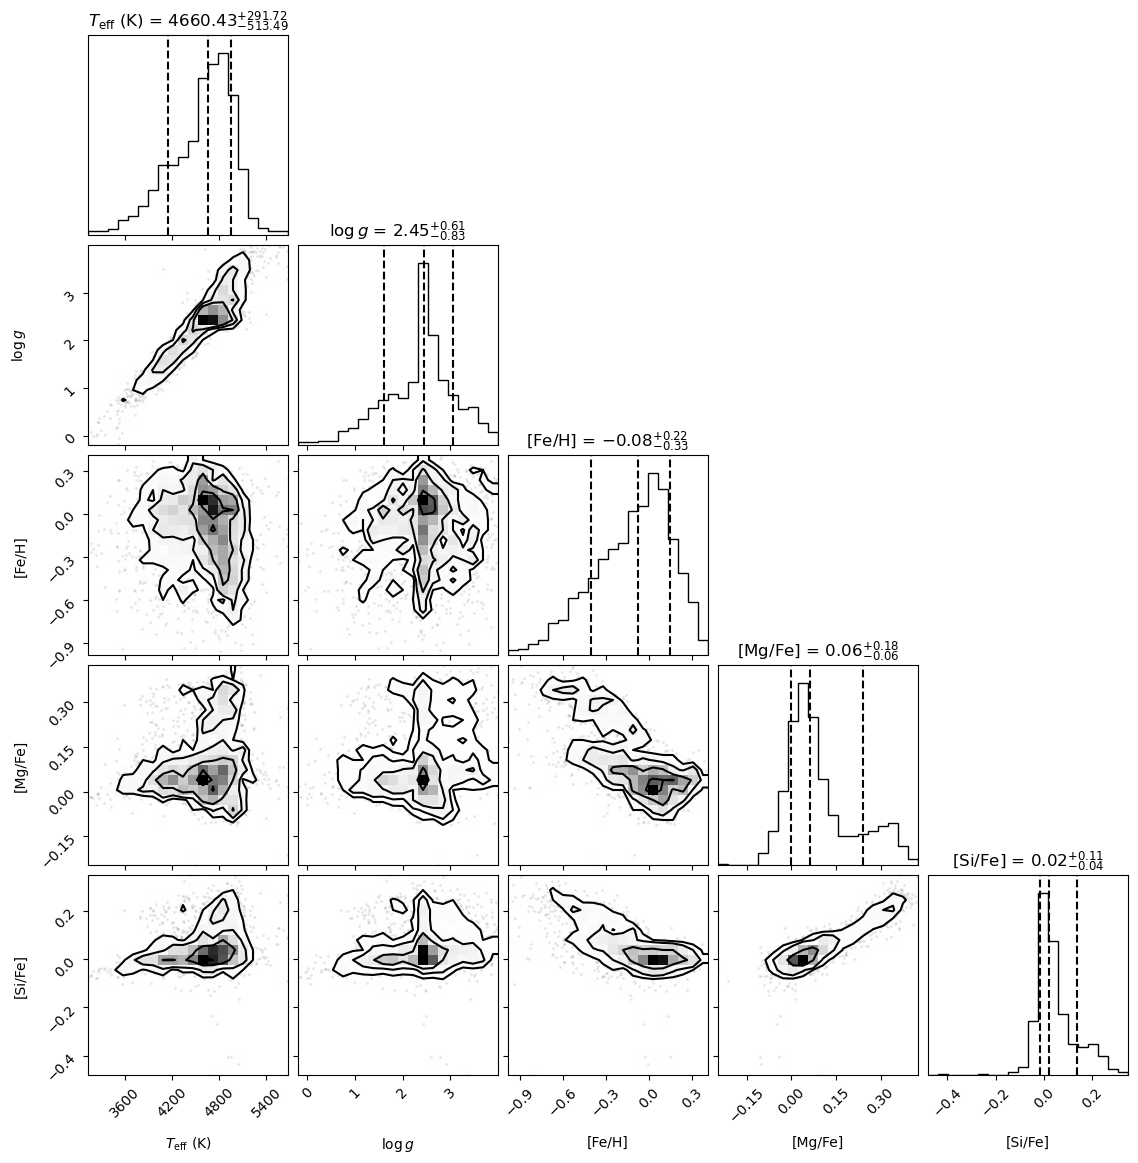

In [18]:
# Extract the labels for plotting
labels_to_plot = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']
label_data = np.vstack([data_filtered[label] for label in labels_to_plot]).T

# Define labels for the plot
plot_labels = [r'$T_{\mathrm{eff}}$ (K)', r'$\log g$', r'[Fe/H]', r'[Mg/Fe]', r'[Si/Fe]']

# Create the corner plot
figure = corner.corner(
    label_data,
    labels=plot_labels,
    show_titles=True,
    title_fmt='.2f',
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 12}
)
plt.show()

Processed lab2_data/apStar_spectra/apStar-dr17-2M03501997+2458304.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 372


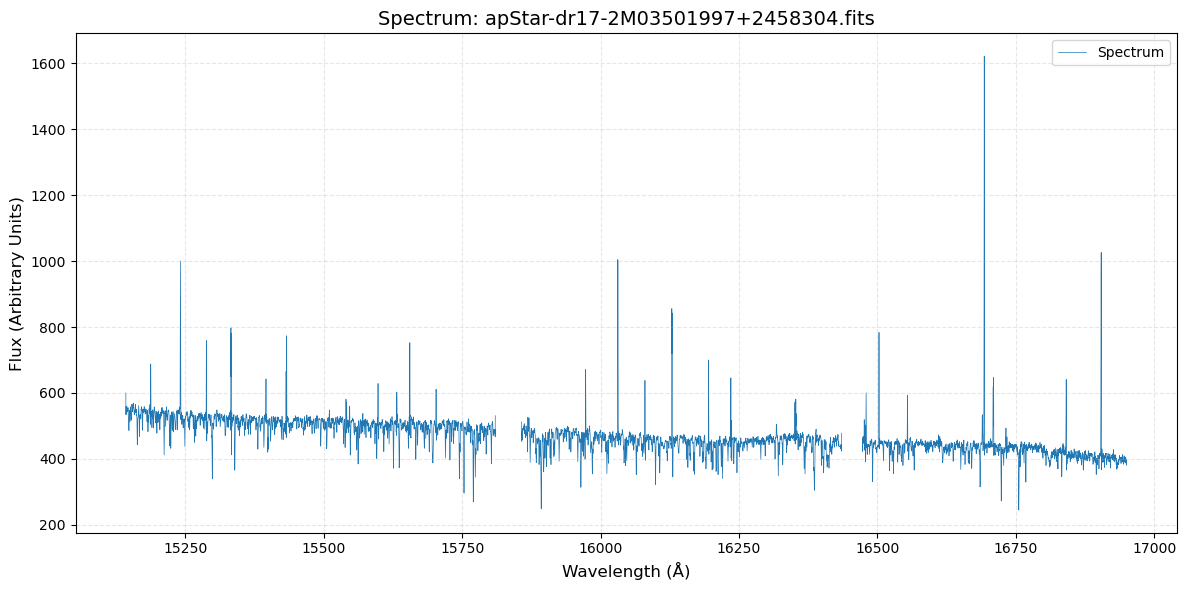

Processed lab2_data/apStar_spectra/apStar-dr17-2M03501997+2458304.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 372


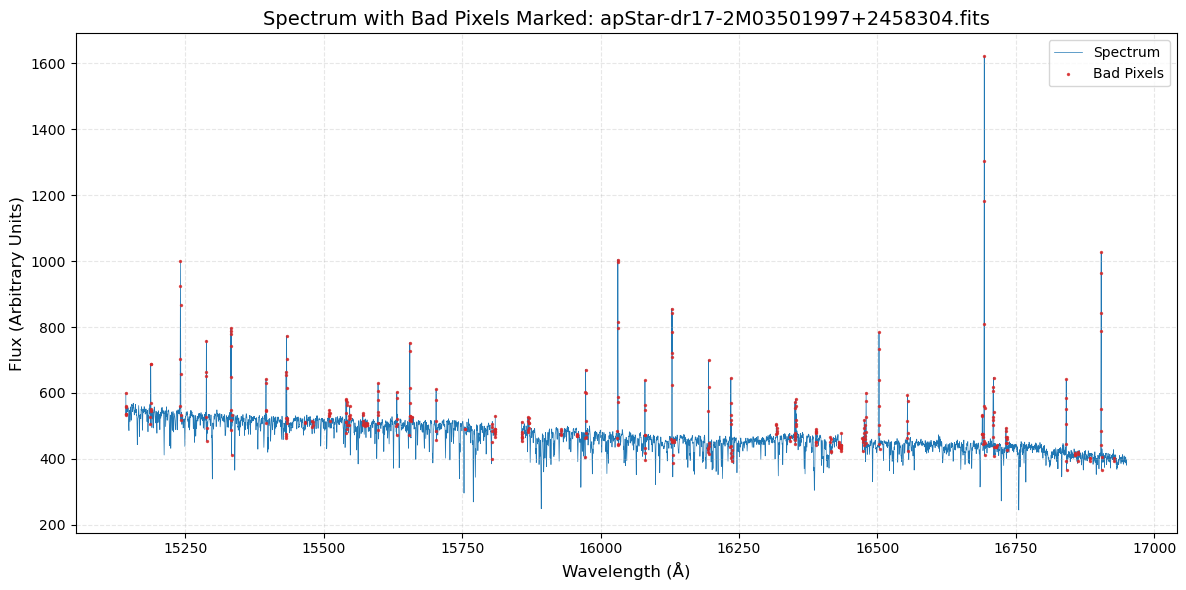

In [19]:
first_apstar_file = spectra_files_final[0]
filename = os.path.basename(first_apstar_file)
unique_id = extract_unique_id(filename)
continuum_pixels_file_path = 'lab2_data/cannon_continuum_apogee.npz'
continuum_wavelengths = load_continuum_pixels(continuum_pixels_file_path)
# Process the spectrum
flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(first_apstar_file, 
                                                                           large_error_value=1e10, 
                                                                           plot=True, 
                                                                           plot_bad_pixels = False)

flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(first_apstar_file, 
                                                                           large_error_value=1e10, 
                                                                           plot=True)

 - After excluding bad pixels: 7990 pixels
 - Wavelength range: 15100.80 Å - 16949.86 Å
   - Chip 15140-15810 Å: 2997 pixels
     - Continuum points in chip: 241
find_closest_indices: Found 241 indices.
find_closest_indices: Example indices: [141 146 192 208 213]
     * Fitted Chebyshev polynomial.
   - Chip 15860-16430 Å: 2446 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.
find_closest_indices: Example indices: [195 203 210 274 310]
     * Fitted Chebyshev polynomial.
   - Chip 16470-16950 Å: 1983 pixels
     - Continuum points in chip: 180
find_closest_indices: Found 180 indices.
find_closest_indices: Example indices: [122 122 123 124 125]
     * Fitted Chebyshev polynomial.
 - Normalization successful.


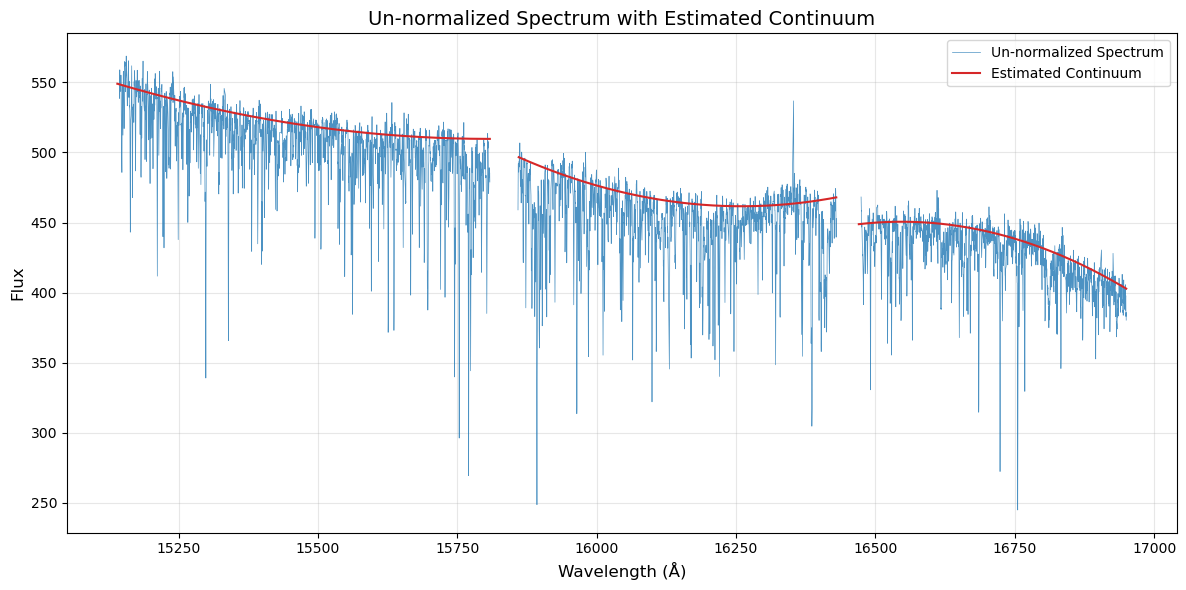

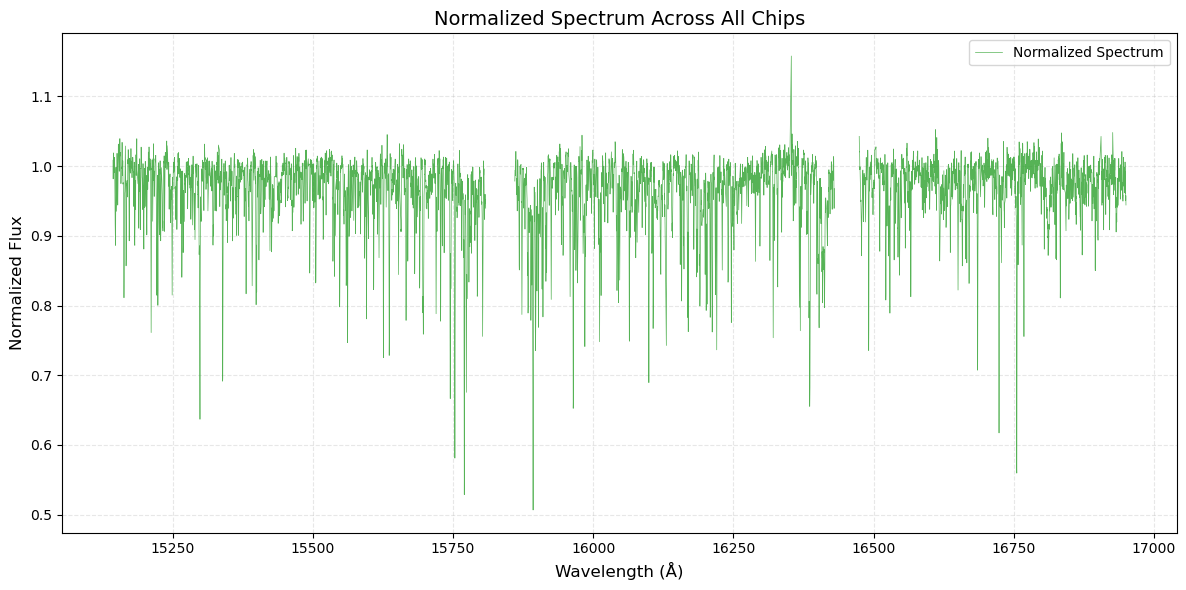

In [20]:
if len(wavelength) == 0:
    logging.warning("Spectrum has no valid pixels after processing.")
else:
    normalized_flux, wavelength = normalize_spectrum(
        flux, wavelength, bad_pixel_mask,
        continuum_wavelengths,
        plot=True  # Set to True to visualize
    )

In [21]:
test_size = 0.5
random_state = 42  # Seed for reproducibility

# Perform the split
train_flux_files, cv_flux_files, train_labels, cv_labels = train_test_split(
    spectra_files_final,
    label_data_final,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

# Verify the shapes of the split datasets
print(f"Total spectra: {len(spectra_files_final)}")
print(f"Training set: {len(train_flux_files)} spectra")
print(f"Cross-validation set: {len(cv_flux_files)} spectra")

Total spectra: 713
Training set: 356 spectra
Cross-validation set: 357 spectra


In [ ]:
# # Step 1: Fit the scaler on the training labels
# scaler = StandardScaler()
# scaler.fit(train_labels)
# # Step 2: Define the target star's ID
# target_star_id = '2M03533659+2512012'
# # Step 3: Find the index of the target star in the training set
# star_index = np.where(label_unique_ids == target_star_id)[0][0]
# # Step 4: Retrieve the labels and observed spectrum for the star
# labels_star = train_labels[star_index]
# observed_flux_star = interpolated_flux_array[star_index]
# # Step 5: Predict the normalized spectrum for this star
# predicted_flux_star = predict_normalized_spectrum(labels_star, theta_lambda, scaler)
# # Step 6: Define the wavelength range for plotting (16000 Å to 16100 Å)
# wavelength_range_mask = (common_wavelength >= 16000) & (common_wavelength <= 16100)
# # Step 7: Apply the wavelength range mask to the data
# wavelength_range = common_wavelength[wavelength_range_mask]
# observed_flux_range = observed_flux_star[wavelength_range_mask]
# predicted_flux_range = predicted_flux_star[wavelength_range_mask]
# # Step 8: Plot the observed and predicted spectra
# plt.figure(figsize=(10, 6))
# plt.plot(wavelength_range, observed_flux_range, label='Observed Spectrum', color='blue', lw=1.5)
# plt.plot(wavelength_range, predicted_flux_range, label='Predicted Spectrum', color='red', linestyle='--', lw=1.5)
# plt.xlabel('Wavelength (Å)')
# plt.ylabel('Normalized Flux')
# plt.title(f'Comparison of Observed and Predicted Spectra for {target_star_id} (16000-16100 Å)')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.show()

In [22]:
# def create_design_matrix(labels, degree=2):
#     """
#     Create a design matrix with polynomial features up to the specified degree.
    
#     Parameters:
#     - labels (ndarray): Array of shape (N, M) where N is the number of samples and M is the number of labels.
#     - degree (int): Degree of the polynomial features.
    
#     Returns:
#     - X (ndarray): Design matrix with polynomial features.
#     - feature_names (list): List of feature names corresponding to the columns in X.
#     """
#     poly = PolynomialFeatures(degree=degree, include_bias=True)
#     X = poly.fit_transform(labels)
#     feature_names = poly.get_feature_names_out()
#     return X, feature_names


In [23]:
# # Select the labels for the design matrix
# labels = ['TEFF', 'LOGG', 'FE_H', 'MG_FE', 'SI_FE']

# # Ensure labels are in the correct order and present in the training set
# if not all(label in data_filtered_final.colnames for label in labels):
#     missing = [label for label in labels if label not in data_filtered_final.colnames]
#     raise KeyError(f"Missing labels in the training data: {missing}")

# # Extract label data
# train_labels = data_filtered_final[labels].to_pandas().values  # Shape: (N_train, 5)

# # Create the design matrix
# X_train, feature_names = create_design_matrix(train_labels, degree=2)

# print(f"Design matrix shape: {X_train.shape}")  # Expected: (356, 16) for 5 labels: 1 + 5 + 10
# print("Feature names:", feature_names)

# #Note: For 5 labels and a second-order polynomial, 
# # you should have 5×(5+3) / 2 = 16 features (including the bias term).

In [24]:
# def compute_log_likelihood(y, y_pred, V):
#     """
#     Compute the log-likelihood of the data given the model.
    
#     Parameters:
#     - y (ndarray): Observed normalized flux values. Shape: (N,)
#     - y_pred (ndarray): Predicted flux values from the model. Shape: (N,)
#     - V (ndarray): Total variance (s^2_lambda + sigma^2). Shape: (N,)
    
#     Returns:
#     - log_likelihood (float): The computed log-likelihood value.
#     """
#     residuals = y - y_pred
#     ll = -0.5 * np.sum((residuals ** 2) / V + np.log(2 * np.pi * V))
#     return ll


In [25]:
# def weighted_least_squares(X, y, W):
#     """
#     Perform weighted least squares fitting.
    
#     Parameters:
#     - X (ndarray): Design matrix. Shape: (N, P)
#     - y (ndarray): Observed values. Shape: (N,)
#     - W (ndarray): Weights. Shape: (N,)
    
#     Returns:
#     - theta (ndarray): Fitted coefficients. Shape: (P,)
#     """
#     # Compute weighted design matrix
#     XW = X * W[:, np.newaxis]  # Shape: (N, P)

#     # Compute (X^T W X)
#     XtWX = XW.T @ X  # Shape: (P, P)

#     # Compute (X^T W y)
#     XtWy = XW.T @ y  # Shape: (P,)

#     # Solve for theta
#     try:
#         theta = np.linalg.solve(XtWX, XtWy)
#     except np.linalg.LinAlgError:
#         theta = np.full(X.shape[1], np.nan)  # In case of singular matrix

#     return theta


In [26]:
# def fit_pixel(y, sigma, X, s2_grid):
#     """
#     Fit the model for a single wavelength pixel.
    
#     Parameters:
#     - y (ndarray): Observed normalized flux values for the pixel. Shape: (N,)
#     - sigma (ndarray): Uncertainties in the normalized flux. Shape: (N,)
#     - X (ndarray): Design matrix. Shape: (N, P)
#     - s2_grid (ndarray): Grid of s^2_lambda values to search over.
    
#     Returns:
#     - theta_best (ndarray): Best-fit coefficients. Shape: (P,)
#     - s2_best (float): Best-fit intrinsic scatter.
#     """
#     log_likelihoods = []
#     theta_grid = []

#     for s2 in s2_grid:
#         V = s2 + sigma ** 2  # Total variance
#         W = 1.0 / V  # Weights

#         theta = weighted_least_squares(X, y, W)
#         theta_grid.append(theta)

#         y_pred = X @ theta
#         ll = compute_log_likelihood(y, y_pred, V)
#         log_likelihoods.append(ll)

#     log_likelihoods = np.array(log_likelihoods)
#     theta_grid = np.array(theta_grid)  # Shape: (len(s2_grid), P)

#     # Find the index of the maximum log-likelihood
#     max_idx = np.argmax(log_likelihoods)

#     # Retrieve the best-fit parameters
#     theta_best = theta_grid[max_idx]
#     s2_best = s2_grid[max_idx]

#     return theta_best, s2_best

In [27]:
# def process_spectra_list(spectra_files, continuum_wavelengths, plot=False):
#     """
#     Process a list of spectral FITS files: mask bad pixels and normalize.

#     Parameters:
#     - spectra_files (list): List of paths to spectral FITS files.
#     - continuum_wavelengths (ndarray): Array of continuum wavelengths for normalization.
#     - plot (bool): Whether to plot each spectrum.

#     Returns:
#     - normalized_flux_list (list): List of normalized flux arrays.
#     - error_list (list): List of error arrays.
#     - wavelength_list (list): List of wavelength arrays corresponding to each spectrum.
#     """
#     normalized_flux_list = []
#     error_list = []
#     wavelength_list = []

#     for file in tqdm(spectra_files, desc="Processing Spectra"):
#         # Process the spectrum: mask bad pixels
#         flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(
#             file, 
#             large_error_value=1e10, 
#             plot=False, 
#             plot_bad_pixels=False
#         )

#         if len(wavelength) == 0:
#             logging.warning(f"Spectrum {file} has no valid pixels after processing. Skipping.")
#             continue

#         # Normalize the spectrum
#         normalized_flux, norm_wavelength = normalize_spectrum(
#             flux, 
#             wavelength, 
#             bad_pixel_mask, 
#             continuum_wavelengths, 
#             plot=False  # Set to True if you want to visualize each normalization
#         )

#         normalized_flux_list.append(normalized_flux)
#         error_list.append(error)
#         wavelength_list.append(norm_wavelength)

#     return normalized_flux_list, error_list, wavelength_list


In [28]:
# train_normalized_flux, train_errors, train_wavelengths = process_spectra_list(
#     train_flux_files,
#     continuum_wavelengths,
#     plot=False
# )

# all_wavelengths = train_wavelengths  # List of ndarrays

# # Find the maximum of the minimum wavelengths and the minimum of the maximum wavelengths
# min_wave = max([wl.min() for wl in all_wavelengths])
# max_wave = min([wl.max() for wl in all_wavelengths])

# print(f"Common wavelength range: {min_wave:.2f} Å - {max_wave:.2f} Å")

# # Calculate the smallest wavelength step across all spectra
# delta_lambdas = [np.min(np.diff(wl)) for wl in all_wavelengths]
# min_delta_lambda = min(delta_lambdas)

# print(f"Minimum wavelength step across spectra: {min_delta_lambda:.4f} Å")

# # Define the common wavelength grid
# common_wavelength = np.arange(min_wave, max_wave, min_delta_lambda)

# print(f"Number of wavelength points in common grid: {len(common_wavelength)}")


In [29]:
# # Initialize lists to hold interpolated flux and error arrays
# interpolated_flux_list = []
# interpolated_error_list = []

# # Function to interpolate a single spectrum
# def interpolate_spectrum(wavelength, flux, error, target_wavelength):
#     """
#     Interpolate a spectrum onto the target wavelength grid and trim arrays to match lengths.
    
#     Parameters:
#     - wavelength (ndarray): Original wavelength array.
#     - flux (ndarray): Original flux array.
#     - error (ndarray): Original error array.
#     - target_wavelength (ndarray): Target wavelength grid.
    
#     Returns:
#     - interpolated_flux (ndarray): Flux interpolated onto the target grid.
#     - interpolated_error (ndarray): Error interpolated onto the target grid.
#     """
#     # Trim error array to match the wavelength length
#     if len(wavelength) != len(error):
#         error = error[:len(wavelength)]  # Trim the error array to match wavelength length
    
#     # Create interpolation functions with linear interpolation
#     interp_flux_func = interp1d(wavelength, flux, kind='linear', bounds_error=False, fill_value=np.nan)
#     interp_error_func = interp1d(wavelength, error, kind='linear', bounds_error=False, fill_value=np.nan)
    
#     # Interpolate flux and error onto the target grid
#     interpolated_flux = interp_flux_func(target_wavelength)
#     interpolated_error = interp_error_func(target_wavelength)
    
#     return interpolated_flux, interpolated_error

# # Loop through all training spectra and interpolate
# for i in tqdm(range(len(train_normalized_flux)), desc="Interpolating Spectra"):
#     wl = train_wavelengths[i]
#     flux = train_normalized_flux[i]
#     error = train_errors[i]
    
#     # Check if the length of wavelength matches flux arrays (error will be trimmed)
#     if len(wl) != len(flux):
#         print(f"Spectrum {i}: Mismatched lengths - Wavelength: {len(wl)}, Flux: {len(flux)}, Error: {len(error)}")
#         continue  # Skip this spectrum due to mismatched lengths between wavelength and flux
    
#     # Interpolate flux and error
#     interp_flux, interp_error = interpolate_spectrum(wl, flux, error, common_wavelength)
    
#     interpolated_flux_list.append(interp_flux)
#     interpolated_error_list.append(interp_error)

# # Convert the lists to NumPy arrays after interpolation
# interpolated_flux_array = np.array(interpolated_flux_list)
# interpolated_error_array = np.array(interpolated_error_list)

# print(f"Interpolated {len(interpolated_flux_array)} spectra successfully.")


In [30]:
# # Check that all interpolated flux arrays have the same length as the common wavelength grid
# if all(len(flux) == len(common_wavelength) for flux in interpolated_flux_list):
#     print(f"All interpolated flux arrays have the expected length: {len(common_wavelength)}")
# else:
#     print("Mismatch found in the length of interpolated flux arrays.")

# # Check the error arrays
# if all(len(error) == len(common_wavelength) for error in interpolated_error_list):
#     print(f"All interpolated error arrays have the expected length: {len(common_wavelength)}")
# else:
#     print("Mismatch found in the length of interpolated error arrays.")


In [31]:
# # Assuming 'train_labels' is already defined and corresponds to the spectra
# X_train, feature_names = create_design_matrix(train_labels, degree=2)

# print(f"Design matrix shape: {X_train.shape}")  # Expected: (N_train, 16)
# print("Feature names:", feature_names)


In [32]:
# # Define the grid for s^2_lambda (intrinsic scatter)
# s2_grid = np.logspace(-5, 1, 100)  # From 1e-5 to 10, 100 points

# n_pixels = interpolated_flux_array.shape[1]  # Number of wavelength pixels
# n_features = X_train.shape[1]  # Number of polynomial features (16)

# # Initialize arrays to store fitted parameters
# theta_lambda = np.zeros((n_pixels, n_features))  # Shape: (n_pixels, 16)
# s2_lambda = np.zeros(n_pixels)  # Shape: (n_pixels,)

# # Fit the model for each wavelength pixel
# print("Fitting the spectral model for each wavelength pixel...")

# for i in tqdm(range(n_pixels), desc="Fitting Pixels"):
#     y = interpolated_flux_array[:, i]  # Observed flux values for the current pixel
#     sigma = interpolated_error_array[:, i]  # Uncertainties for the current pixel
    
#     # Subset the design matrix to the size of the current subset of spectra (356)
#     X_train_subset = X_train[:len(y)]  # This ensures the matrix matches the size of y
    
#     # Fit the pixel to find the best theta_lambda and s2_lambda, handling NaNs
#     theta_best, s2_best = fit_pixel(y, sigma, X_train_subset, s2_grid)
    
#     theta_lambda[i, :] = theta_best
#     s2_lambda[i] = s2_best

# print("Model fitting complete.")


In [33]:
# def rescale_labels(labels, scaler):
#     """
#     Rescale the stellar labels to be of order unity using a provided scaler.
    
#     Parameters:
#     - labels (ndarray): Array of label data (shape: (N, M)).
#     - scaler (StandardScaler): Fitted scaler object to use for normalization.
    
#     Returns:
#     - rescaled_labels (ndarray): Rescaled label data.
#     """
#     rescaled_labels = scaler.transform(labels)
#     return rescaled_labels


In [34]:
# def create_design_matrix_for_labels(labels, scaler, degree=2):
#     """
#     Create the design matrix for a given label vector.

#     Parameters:
#     - labels (ndarray): The stellar label vector for a star (shape: (M,)).
#     - scaler (StandardScaler): Scaler used to normalize the labels.
#     - degree (int): Degree of polynomial features to generate.
    
#     Returns:
#     - X (ndarray): Design matrix with polynomial features (shape: (1, P)).
#     """
#     # Rescale the labels to be of order unity
#     labels_rescaled = rescale_labels(labels.reshape(1, -1), scaler)
    
#     # Generate polynomial features (same as during training)
#     poly = PolynomialFeatures(degree=degree, include_bias=True)
#     X = poly.fit_transform(labels_rescaled)
    
#     return X

In [35]:
# def predict_normalized_spectrum(labels, theta_lambda, scaler, degree=2):
#     """
#     Predict the normalized spectrum for a star based on its label vector.
    
#     Parameters:
#     - labels (ndarray): The stellar label vector for the star (shape: (M,)).
#     - theta_lambda (ndarray): The learned model parameters (shape: (n_pixels, P)).
#     - scaler (StandardScaler): Fitted scaler used to rescale the labels.
#     - degree (int): Degree of polynomial features.
    
#     Returns:
#     - predicted_flux (ndarray): Predicted normalized flux (shape: (n_pixels,)).
#     """
#     # Create the design matrix for the provided labels
#     X = create_design_matrix_for_labels(labels, scaler, degree)
    
#     # Predict the normalized flux for each wavelength pixel using theta_lambda
#     predicted_flux = X @ theta_lambda.T  # Shape: (1, n_pixels)
    
#     return predicted_flux.flatten()  # Return as a 1D array

In [36]:
# print("train_labels shape:", train_labels.shape)
# print("Example labels:", train_labels[0])
# print("theta_lambda shape:", theta_lambda.shape)
# print("Example theta row:", theta_lambda[0])

In [37]:
# print("Target star labels:", labels_star)
# print("Are there any NaNs in theta_lambda?", np.any(np.isnan(theta_lambda)))
# print("Are there any NaNs in predicted_flux?", np.any(np.isnan(predicted_flux_star)))

In [43]:
def process_spectra_list(spectra_files, continuum_wavelengths, plot=False):
    """
    Process a list of spectral FITS files: mask bad pixels and normalize.

    Parameters:
    - spectra_files (list): List of paths to spectral FITS files.
    - continuum_wavelengths (ndarray): Array of continuum wavelengths for normalization.
    - plot (bool): Whether to plot each spectrum.

    Returns:
    - normalized_flux_list (list): List of normalized flux arrays.
    - error_list (list): List of error arrays.
    - wavelength_list (list): List of wavelength arrays corresponding to each spectrum.
    """
    normalized_flux_list = []
    error_list = []
    wavelength_list = []

    for file in tqdm(spectra_files, desc="Processing Spectra"):
        # Process the spectrum: mask bad pixels
        flux, error, wavelength, bad_pixel_mask, _ = process_spectrum_with_bitmask(
            file, 
            large_error_value=1e10, 
            plot=False, 
            plot_bad_pixels=False
        )

        if len(wavelength) == 0:
            logging.warning(f"Spectrum {file} has no valid pixels after processing. Skipping.")
            continue

        # Normalize the spectrum
        normalized_flux, norm_wavelength = normalize_spectrum(
            flux, 
            wavelength, 
            bad_pixel_mask, 
            continuum_wavelengths, 
            plot=False  # Set to True if you want to visualize each normalization
        )

        normalized_flux_list.append(normalized_flux)
        error_list.append(error)
        wavelength_list.append(norm_wavelength)

    return normalized_flux_list, error_list, wavelength_list


In [45]:
train_normalized_flux, train_errors, train_wavelengths = process_spectra_list(
    train_flux_files,
    continuum_wavelengths,
    plot=False
)

all_wavelengths = train_wavelengths  # List of ndarrays

# Find the maximum of the minimum wavelengths and the minimum of the maximum wavelengths
min_wave = max([wl.min() for wl in all_wavelengths])
max_wave = min([wl.max() for wl in all_wavelengths])

print(f"Common wavelength range: {min_wave:.2f} Å - {max_wave:.2f} Å")

# Calculate the smallest wavelength step across all spectra
delta_lambdas = [np.min(np.diff(wl)) for wl in all_wavelengths]
min_delta_lambda = min(delta_lambdas)

print(f"Minimum wavelength step across spectra: {min_delta_lambda:.4f} Å")

# Define the common wavelength grid
common_wavelength = np.arange(min_wave, max_wave, min_delta_lambda)

print(f"Number of wavelength points in common grid: {len(common_wavelength)}")


Processing Spectra:  21%|████▎                | 73/356 [00:00<00:00, 370.64it/s]

Processed lab2_data/apStar_spectra/apStar-dr17-2M04020164+2556160.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 344
 - After excluding bad pixels: 8018 pixels
 - Wavelength range: 15100.80 Å - 16949.86 Å
   - Chip 15140-15810 Å: 3019 pixels
     - Continuum points in chip: 241
find_closest_indices: Found 241 indices.
find_closest_indices: Example indices: [137 142 188 204 209]
     * Fitted Chebyshev polynomial.
   - Chip 15860-16430 Å: 2428 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.
find_closest_indices: Example indices: [186 194 201 261 301]
     * Fitted Chebyshev polynomial.
   - Chip 16470-16950 Å: 2013 pixels
     - Continuum points in chip: 180
find_closest_indices: Found 180 indices.
find_closest_indices: Example indices: [135 137 138 139 140]
     * Fitted Chebyshev polynomial.
 - Normalization successful.
Processed lab2_data/apStar_spectra/apStar-dr17-2M03571952+2425571.fits:
 - Number of valid pixels: 8362
 - Number 

Processing Spectra:  45%|█████████           | 161/356 [00:00<00:00, 415.66it/s]

   - Chip 15860-16430 Å: 2447 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.
find_closest_indices: Example indices: [195 203 210 274 314]
     * Fitted Chebyshev polynomial.
   - Chip 16470-16950 Å: 2000 pixels
     - Continuum points in chip: 180
find_closest_indices: Found 180 indices.
find_closest_indices: Example indices: [120 122 123 124 125]
     * Fitted Chebyshev polynomial.
 - Normalization successful.
Processed lab2_data/apStar_spectra/apStar-dr17-2M19380059+2323265.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 58
 - After excluding bad pixels: 8304 pixels
 - Wavelength range: 15100.80 Å - 16949.86 Å
   - Chip 15140-15810 Å: 3119 pixels
     - Continuum points in chip: 241
find_closest_indices: Found 241 indices.
find_closest_indices: Example indices: [147 152 198 214 219]
     * Fitted Chebyshev polynomial.
   - Chip 15860-16430 Å: 2533 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.


Processing Spectra:  57%|███████████▍        | 203/356 [00:00<00:00, 413.75it/s]

Processed lab2_data/apStar_spectra/apStar-dr17-2M19202354+3751229.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 401
 - After excluding bad pixels: 7961 pixels
 - Wavelength range: 15100.80 Å - 16949.86 Å
   - Chip 15140-15810 Å: 2978 pixels
     - Continuum points in chip: 241
find_closest_indices: Found 241 indices.
find_closest_indices: Example indices: [142 147 193 209 214]
     * Fitted Chebyshev polynomial.
   - Chip 15860-16430 Å: 2427 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.
find_closest_indices: Example indices: [170 178 185 249 289]
     * Fitted Chebyshev polynomial.
   - Chip 16470-16950 Å: 1990 pixels
     - Continuum points in chip: 180
find_closest_indices: Found 180 indices.
find_closest_indices: Example indices: [125 125 125 126 126]
     * Fitted Chebyshev polynomial.
 - Normalization successful.
Processed lab2_data/apStar_spectra/apStar-dr17-2M19274322+3904194.fits:
 - Number of valid pixels: 8362
 - Number 

Processing Spectra:  80%|████████████████    | 285/356 [00:00<00:00, 384.94it/s]

   - Chip 15860-16430 Å: 2509 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.
find_closest_indices: Example indices: [195 203 210 274 314]
     * Fitted Chebyshev polynomial.
   - Chip 16470-16950 Å: 2040 pixels
     - Continuum points in chip: 180
find_closest_indices: Found 180 indices.
find_closest_indices: Example indices: [131 132 133 134 135]
     * Fitted Chebyshev polynomial.
 - Normalization successful.
Processed lab2_data/apStar_spectra/apStar-dr17-2M19395228+2347414.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 48
 - After excluding bad pixels: 8314 pixels
 - Wavelength range: 15100.80 Å - 16949.86 Å
   - Chip 15140-15810 Å: 3122 pixels
     - Continuum points in chip: 241
find_closest_indices: Found 241 indices.
find_closest_indices: Example indices: [147 152 198 214 219]
     * Fitted Chebyshev polynomial.
   - Chip 15860-16430 Å: 2546 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.


Processing Spectra: 100%|████████████████████| 356/356 [00:00<00:00, 393.61it/s]

Processed lab2_data/apStar_spectra/apStar-dr17-2M03540091+2434180.fits:
 - Number of valid pixels: 8362
 - Number of bad pixels: 159
 - After excluding bad pixels: 8203 pixels
 - Wavelength range: 15100.80 Å - 16949.86 Å
   - Chip 15140-15810 Å: 3106 pixels
     - Continuum points in chip: 241
find_closest_indices: Found 241 indices.
find_closest_indices: Example indices: [141 146 192 208 213]
     * Fitted Chebyshev polynomial.
   - Chip 15860-16430 Å: 2525 pixels
     - Continuum points in chip: 108
find_closest_indices: Found 108 indices.
find_closest_indices: Example indices: [195 203 210 274 314]
     * Fitted Chebyshev polynomial.
   - Chip 16470-16950 Å: 2019 pixels
     - Continuum points in chip: 180
find_closest_indices: Found 180 indices.
find_closest_indices: Example indices: [139 141 142 143 144]
     * Fitted Chebyshev polynomial.
 - Normalization successful.
Processed lab2_data/apStar_spectra/apStar-dr17-2M19382143+2349348.fits:
 - Number of valid pixels: 8362
 - Number 

In [46]:
# Initialize lists to hold interpolated flux and error arrays
interpolated_flux_list = []
interpolated_error_list = []

# Function to interpolate a single spectrum
def interpolate_spectrum(wavelength, flux, error, target_wavelength):
    """
    Interpolate a spectrum onto the target wavelength grid and trim arrays to match lengths.
    
    Parameters:
    - wavelength (ndarray): Original wavelength array.
    - flux (ndarray): Original flux array.
    - error (ndarray): Original error array.
    - target_wavelength (ndarray): Target wavelength grid.
    
    Returns:
    - interpolated_flux (ndarray): Flux interpolated onto the target grid.
    - interpolated_error (ndarray): Error interpolated onto the target grid.
    """
    # Trim error array to match the wavelength length
    if len(wavelength) != len(error):
        error = error[:len(wavelength)]  # Trim the error array to match wavelength length
    
    # Create interpolation functions with linear interpolation
    interp_flux_func = interp1d(wavelength, flux, kind='linear', bounds_error=False, fill_value=np.nan)
    interp_error_func = interp1d(wavelength, error, kind='linear', bounds_error=False, fill_value=np.nan)
    
    # Interpolate flux and error onto the target grid
    interpolated_flux = interp_flux_func(target_wavelength)
    interpolated_error = interp_error_func(target_wavelength)
    
    return interpolated_flux, interpolated_error

# Loop through all training spectra and interpolate
for i in tqdm(range(len(train_normalized_flux)), desc="Interpolating Spectra"):
    wl = train_wavelengths[i]
    flux = train_normalized_flux[i]
    error = train_errors[i]
    
    # Check if the length of wavelength matches flux arrays (error will be trimmed)
    if len(wl) != len(flux):
        print(f"Spectrum {i}: Mismatched lengths - Wavelength: {len(wl)}, Flux: {len(flux)}, Error: {len(error)}")
        continue  # Skip this spectrum due to mismatched lengths between wavelength and flux
    
    # Interpolate flux and error
    interp_flux, interp_error = interpolate_spectrum(wl, flux, error, common_wavelength)
    
    interpolated_flux_list.append(interp_flux)
    interpolated_error_list.append(interp_error)

# Convert the lists to NumPy arrays after interpolation
interpolated_flux_array = np.array(interpolated_flux_list)
interpolated_error_array = np.array(interpolated_error_list)

print(f"Interpolated {len(interpolated_flux_array)} spectra successfully.")


Interpolating Spectra: 100%|████████████████| 356/356 [00:00<00:00, 1565.54it/s]

Interpolated 356 spectra successfully.


In [49]:
def compute_log_likelihood(y, y_pred, V):
    """
    Compute the log-likelihood of the data given the model.
    
    Parameters:
    - y (ndarray): Observed normalized flux values. Shape: (N,)
    - y_pred (ndarray): Predicted flux values from the model. Shape: (N,)
    - V (ndarray): Total variance (s^2_lambda + sigma^2). Shape: (N,)
    
    Returns:
    - log_likelihood (float): The computed log-likelihood value.
    """
    residuals = y - y_pred
    ll = -0.5 * np.sum((residuals ** 2) / V + np.log(2 * np.pi * V))
    return ll


def weighted_least_squares(X, y, W):
    """
    Perform weighted least squares fitting with improved numerical stability.
    """
    # Add small regularization term to diagonal for stability
    epsilon = 1e-8
    
    # Compute weighted design matrix
    XW = X * np.sqrt(W)[:, np.newaxis]  # Using sqrt(W) for better conditioning
    
    # Compute (X^T W X)
    XtWX = XW.T @ XW  # Shape: (P, P)
    
    # Add regularization to diagonal
    XtWX += np.eye(XtWX.shape[0]) * epsilon
    
    # Compute (X^T W y)
    XtWy = XW.T @ (y * np.sqrt(W))  # Shape: (P,)
    
    # Solve using SVD for better stability
    try:
        theta = np.linalg.solve(XtWX, XtWy)
        if np.any(np.isnan(theta)):
            raise np.linalg.LinAlgError
    except np.linalg.LinAlgError:
        # Use pseudo-inverse if direct solve fails
        theta = np.linalg.pinv(XtWX) @ XtWy
    
    return theta

def create_design_matrix(labels, degree=2):
    """
    Create a design matrix with polynomial features up to the specified degree.
    Ensures consistent feature generation and proper scaling.
    """
    # Scale the labels to prevent numerical issues
    scaler = StandardScaler()
    scaled_labels = scaler.fit_transform(labels)
    
    # Generate polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X = poly.fit_transform(scaled_labels)
    
    # Store the scaler and feature names
    feature_names = poly.get_feature_names_out()
    
    return X, feature_names, scaler

def fit_pixel(y, sigma, X, s2_grid):
    """
    Fit the model for a single wavelength pixel with improved stability.
    """
    log_likelihoods = []
    theta_grid = []
    
    # Remove any NaN values
    valid_mask = ~np.isnan(y) & ~np.isnan(sigma)
    y = y[valid_mask]
    sigma = sigma[valid_mask]
    X = X[valid_mask]
    
    if len(y) < X.shape[1]:
        return np.full(X.shape[1], np.nan), np.nan
    
    for s2 in s2_grid:
        V = s2 + sigma ** 2  # Total variance
        W = 1.0 / V  # Weights
        
        # Skip if all weights are invalid
        if not np.any(np.isfinite(W)):
            continue
            
        theta = weighted_least_squares(X, y, W)
        theta_grid.append(theta)
        
        y_pred = X @ theta
        ll = compute_log_likelihood(y, y_pred, V)
        log_likelihoods.append(ll)
    
    if not log_likelihoods:
        return np.full(X.shape[1], np.nan), np.nan
    
    log_likelihoods = np.array(log_likelihoods)
    theta_grid = np.array(theta_grid)
    
    # Find best parameters
    max_idx = np.argmax(log_likelihoods)
    theta_best = theta_grid[max_idx]
    s2_best = s2_grid[max_idx]
    
    return theta_best, s2_best

# Prediction function with validation
def predict_normalized_spectrum(labels, theta_lambda, scaler, degree=2):
    """
    Predict the normalized spectrum with input validation.
    """
    # Scale the labels using the same scaler used in training
    scaled_labels = scaler.transform(labels.reshape(1, -1))
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X = poly.fit_transform(scaled_labels)
    
    # Predict the normalized flux
    predicted_flux = X @ theta_lambda.T
    
    return predicted_flux.flatten()

Training subset shape: (356, 5)
Interpolated flux array shape: (356, 8789)
Design matrix shape: (356, 21)
Feature names: ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4'
 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x2^2' 'x2 x3' 'x2 x4' 'x3^2' 'x3 x4'
 'x4^2']
Fitting the spectral model for each wavelength pixel...


100%|██████████████████████████████████████| 8789/8789 [00:27<00:00, 321.25it/s]


Percentage of NaN values in theta_lambda: 7.39560814654682 %


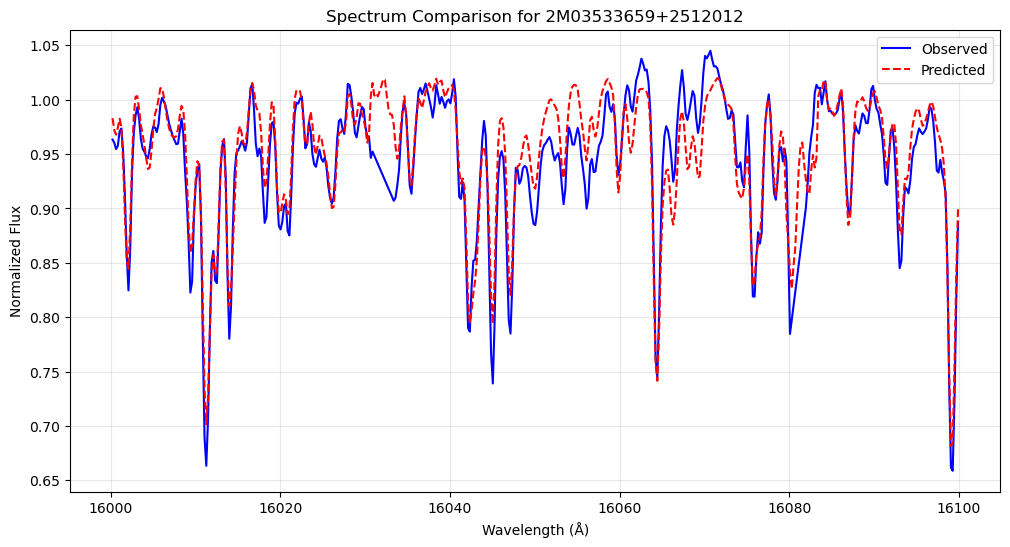

In [51]:
# First, ensure we're using only the training subset of labels
train_labels_subset = train_labels[:len(interpolated_flux_array)]
print(f"Training subset shape: {train_labels_subset.shape}")
print(f"Interpolated flux array shape: {interpolated_flux_array.shape}")

# Create the design matrix using only the training subset
X_train, feature_names, scaler = create_design_matrix(train_labels_subset, degree=2)
print(f"Design matrix shape: {X_train.shape}")
print("Feature names:", feature_names)

# Define the grid for s^2_lambda (intrinsic scatter)
s2_grid = np.logspace(-5, 1, 50)  # Reduced number of grid points for stability
n_pixels = interpolated_flux_array.shape[1]
n_features = X_train.shape[1]

# Initialize arrays to store fitted parameters
theta_lambda = np.zeros((n_pixels, n_features))
s2_lambda = np.zeros(n_pixels)

# Fit the model for each wavelength pixel
print("Fitting the spectral model for each wavelength pixel...")
for i in tqdm(range(n_pixels)):
    y = interpolated_flux_array[:, i]
    sigma = interpolated_error_array[:, i]
    
    theta_best, s2_best = fit_pixel(y, sigma, X_train, s2_grid)
    theta_lambda[i, :] = theta_best
    s2_lambda[i] = s2_best

# Verify the results
print("Percentage of NaN values in theta_lambda:", 
      100 * np.isnan(theta_lambda).mean(), "%")

# For prediction, ensure we're using the correct index for the target star
# We need to map the target star index to the training subset
target_star_id = '2M03533659+2512012'
star_index = np.where(label_unique_ids[:len(interpolated_flux_array)] == target_star_id)[0][0]
labels_star = train_labels_subset[star_index]

# Make prediction
predicted_flux_star = predict_normalized_spectrum(labels_star, theta_lambda, scaler)

# Plot the results
plt.figure(figsize=(12, 6))
wavelength_range_mask = (common_wavelength >= 16000) & (common_wavelength <= 16100)
wavelength_range = common_wavelength[wavelength_range_mask]
observed_flux_star = interpolated_flux_array[star_index]
observed_flux_range = observed_flux_star[wavelength_range_mask]
predicted_flux_range = predicted_flux_star[wavelength_range_mask]

plt.plot(wavelength_range, observed_flux_range, label='Observed', color='blue', lw=1.5)
plt.plot(wavelength_range, predicted_flux_range, label='Predicted', color='red', 
         linestyle='--', lw=1.5)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Normalized Flux')
plt.title(f'Spectrum Comparison for {target_star_id}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()